In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as thdata
import torch.nn as nn
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
import os
from sampler import ImbalancedDatasetSampler

In [2]:
fileNames = os.listdir('../Data')
newFileNames = []
outputFileNames = os.listdir('OriVectUsers/')

for name in fileNames:
    if 'User' in name:
        newFileNames.append(name)
        
newFileNames.sort()
outputFileNames.sort()

test_X_fName = newFileNames.pop(len(newFileNames)-1)

test_y_fName = outputFileNames.pop(len(outputFileNames)-1)

In [3]:
def centAndScale(magData):

    x = [float(row[0]) for row in magData]
    y = [float(row[1]) for row in magData]
    z = [float(row[2]) for row in magData]

    plt.scatter(x, y, label='XY')
    plt.scatter(x, z, label='XZ')
    plt.scatter(y, z, label='YZ')

    plt.xlabel('x label')
    plt.ylabel('y label')

    plt.show()

    offset_x = (max(x) + min(x)) / 2
    offset_y = (max(y) + min(y)) / 2
    offset_z = (max(z) + min(z)) / 2

    corrected_mag_data = np.array([[0, 0, 0]])

    for row in magData:

        corrected_x = float(row[0]) - offset_x
        corrected_y = float(row[1]) - offset_y
        corrected_z = float(row[2]) - offset_z

        corr_list = np.array([corrected_x, corrected_y, corrected_z])
        corr_list = corr_list.reshape((1, 3))

        corrected_mag_data = np.append(corrected_mag_data, corr_list, axis=0)

    corrected_mag_data = corrected_mag_data[1:]

    plt.scatter(corrected_mag_data[:, 0], corrected_mag_data[:, 1], label='XY')
    plt.scatter(corrected_mag_data[:, 0], corrected_mag_data[:, 2], label='XZ')
    plt.scatter(corrected_mag_data[:, 1], corrected_mag_data[:, 2], label='YZ')

    plt.xlabel('x label')
    plt.ylabel('y label')

    plt.show()

    norm_corr_mag_data = Normalizer().fit_transform(corrected_mag_data)

    return norm_corr_mag_data

In [33]:
class SeqSampleDatset(thdata.Dataset):
    def __init__(self, data, output, size):
        super().__init__()
        self.data = data
        self.output = output
        self.size = size

    def __len__(self):
        return len(self.data) - self.size

    def __getitem__(self, item):
        return self.data[item:item+self.size, :], self.output[item:item+self.size, :]

In [60]:
def parseSheet(userSheetName, outputSheetName, test=False):
    
    user = pd.read_csv(userSheetName)
    userOutput = pd.read_excel(outputSheetName, header=None)

    user.drop(user.columns[[3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16]], axis=1, inplace=True)

    cols = user.columns.tolist()

    userAcc = np.asarray(user[['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)']].values)
    userMag = np.asarray(user[['MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)']].values)
    
    userMag = centAndScale(userMag)
    
    userTensor = np.concatenate((userAcc, userMag), axis=1)
    
    userTensorOut = userOutput.values
    X = torch.as_tensor(userTensor).float()
    y = torch.as_tensor(userTensorOut).float()

    train = SeqSampleDatset(X, y, 50)
    
    return (train, X, y)

In [62]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, layer_size, output_size):

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.layer_size = layer_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):

        hidden = self.init_hidden(X)

        out, hidden = self.rnn(X, hidden)

        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, X):

        return torch.zeros(self.layer_size, X.shape[0], self.hidden_size).float()

In [59]:
input_dim = 6
hidden_dim = 6
layer_dim = 1
output_dim = 6

rnn = RNN(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.MSELoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

count = 0

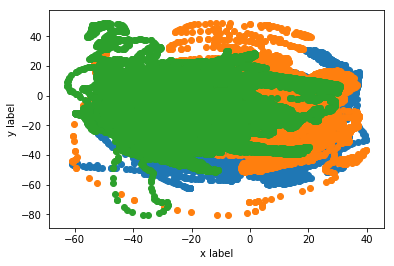

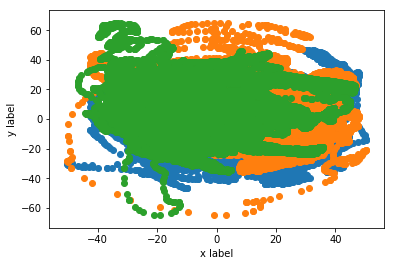

RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cpu and hidden tensor at cuda:0

In [63]:
lossVals = []
totalEpochs = 0
epochList = []

#batch_size = 100
n_iters = 10000

for x in range(7):
    train, X, y = parseSheet(os.path.join("../Data", newFileNames[x], "Data.csv"), os.path.join("OriVectUsers/", outputFileNames[x]))
    
    num_epochs = n_iters / (len(X) / batch_size)
    num_epochs = int(num_epochs)
    
    train_loader = thdata.DataLoader(train, drop_last=True, shuffle=False)
    
    for epoch in range(num_epochs): 
        totalEpochs += 1

        for X, y in train_loader:

            train = X.view(-1, 1, X.shape[2]).float()
            y = y.view(-1, y.shape[2])

            optimizer.zero_grad()

            outputs = rnn(train)

            loss = error(outputs, y)

            loss.backward()

            optimizer.step()

            count += 1
            
            # if count % 250 == 0:
            #
            #     correct = 0
            #     total = 0
            #
            #     for X, y in train_loader:
            #
            #         train = X.view(-1, 1, X.shape[1]).float()
            #
            #         outputs = rnn(train)

        lossVals.append(loss.data.item())
        print('Output:', outputs[0])
        print('True:', y[0])
        print('Loss:', loss.data.item())
        print()

In [ ]:
plt.plot([x for x in range(totalEpochs)], lossVals)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("loss_function.png")

In [ ]:
def calcLoss(test_X_fName, test_y_fName):
    
    test, test_X, test_y = parseSheet(os.path.join("../Data", test_X_fName, "Data.csv"), os.path.join("OriVectUsers/", test_y_fName))
    
    test_X = test_X.view(-1, 1, test_X.shape[1]).float()
    print(test_X.shape)
    outputs = rnn(test_X)
    
    loss = error(outputs, test_y)
    
    print(loss)

In [ ]:
calcLoss(test_X_fName, test_y_fName)